In [69]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report,make_scorer,recall_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier


In [70]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-train-clean.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/stock-market-test-clean.csv')

In [71]:
X = df.copy()
# X = df.drop(columns=['Date','Adj Close','CloseUSD','Volume','RSI14','Open','Year'],axis=1).copy()
y = X.pop('Target')
X_valid = df_test.copy()
y_valid = X_valid.pop('Target')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [72]:
y.value_counts()

0    68651
1    14020
Name: Target, dtype: int64

we will be using cross validation and recall since our data is unbalance

## Baseline Model

In [73]:
model = DummyClassifier(strategy='stratified')


scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
    }


scores = cross_validate(model, X_train, y_train,
                              cv=5,
                              scoring=scoring)

print("Precision scores:\n", scores['test_Precision'].mean())
print("Recall scores:\n", scores['test_Recall'].mean())
print("F1 scores:\n", scores['test_F1'].mean())

# print('Dummy Classifier :', model.score(y_test,pred))
# print(classification_report(y_test,pred))

Precision scores:
 0.501115055190106
Recall scores:
 0.501114973732381
F1 scores:
 0.5011050082000984


## Comparing Model

In [74]:

def train(classifier,name='',graph=False):
    
    scoring = {'Accuracy': 'accuracy',
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    score_dict = cross_validate(classifier, X_test, y_test,
                              cv=5,
                              scoring=scoring)
    
    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier()
            
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],name=model))

In [76]:
scores.sort_values('Recall',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.776489,0.780509,0.778000,0.928984
1,LGBM,0.820723,0.750410,0.778058,0.937964
2,CatBoost,0.810967,0.749652,0.774454,0.936750
3,Decision Tree,0.745111,0.746629,0.745793,0.746629
4,XGBoost,0.826467,0.744556,0.775617,0.937831
5,Random Forest,0.782515,0.740514,0.758434,0.929760


## Model Train

In [77]:
dict_score = cross_validate(LogisticRegression(max_iter=2200), X, y,
                              cv=15,
                              scoring='recall_macro')

In [78]:
dict_score['test_score'].mean()

0.7283244077244543

In [84]:
model = LogisticRegression(max_iter=1200)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     20596
           1       0.63      0.64      0.64      4206

    accuracy                           0.88     24802
   macro avg       0.78      0.78      0.78     24802
weighted avg       0.88      0.88      0.88     24802



We will try moving the threshold as we didn't caught any of the 1 category

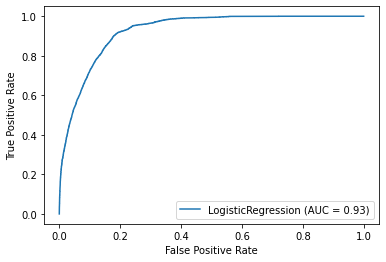

In [85]:
from sklearn import metrics
metrics.plot_roc_curve(model, X_test, y_test)

In [162]:
score = model.predict_proba(X_test)[:, 1]

result = []
threshold = 0.04
for i in score:
    result.append(i > threshold)


In [163]:
print(classification_report(y_test, result, labels=[0,1], zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     20596
           1       0.39      0.97      0.56      4206

    accuracy                           0.74     24802
   macro avg       0.69      0.83      0.69     24802
weighted avg       0.89      0.74      0.77     24802



In [164]:
score = model.predict_proba(X_valid)[:, 1]

result = []
for i in score:
    result.append(i > threshold)

In [165]:
print(classification_report(y_valid, result, labels=[0,1], zero_division=1))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     14391
           1       0.89      0.48      0.62      5758

    accuracy                           0.83     20149
   macro avg       0.86      0.73      0.76     20149
weighted avg       0.84      0.83      0.82     20149

